Per il riconoscimento facciale abbiamo bisogno di seguire i passi indicati nel paper firmato da Turk e Pentland:
- Aquisire un dataset di facce
- Calcolare le eigenfaces dal set di apprendimento conservando solo le M immagini che hanno gli autovalori più alti. Queste M facce rappresentano lo spazio delle facce, questo spazio può essere man mano aggiornato
- Calcolare la distribuzione M dimensionale per ogni individuo proiettando la faccia sullo spazio delle facce

Una volta inizializzato il sistema, possiamo procedere in questo modo:
- Calcolare un set di pesi in base all'immagine fornita e gli autovalori proiettando l'immagine su ogni eigenfaces 
- Determinare se l'immagine è effettivamente un volto controllando che sia abbastanza vicino allo spazio delle facce
- Calcolare i pesi in modo da definire se è una persona che è già segnata o meno
- Opzionalmente si possono aggiornare pesi e spazio delle facce 

In [13]:
import os
import glob 
import numpy as np
import cv2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import math
from PIL import Image



In [14]:
dim = 64

faces_xml = 'haarcascade_frontalface_alt.xml'
#eyes_xml = 'haarcascade_eye.xml'
face_cascade = cv2.CascadeClassifier()
#eyes_cascade = cv2.CascadeClassifier()
if not face_cascade.load(faces_xml):
    print('--(!)Errore durante il caricamento del file xml per le facce')
    exit(0)


#if not eyes_cascade.load(eyes_xml):
#    print('--(!)Error loading eyes cascade')
#    exit(0)

root = "foto64x64"
cwd = os.getcwd()
listDir = os.listdir(root)
tagFoto = {}

for dir in listDir:
    imgs =  glob.glob(f"{root}/{dir}/*.jpg")
    tagFoto[dir] = imgs


In [15]:
'''
def preprocess(face):
    new_img = face
    img_raw = face
    eyes = eyes_cascade.detectMultiScale(face)
    if len(eyes) >= 2:
        eye = eyes[:, 2]
        container1 = []
        for i in range(0, len(eye)):
            container = (eye[i], i)
            container1.append(container)
        df = pd.DataFrame(container1, columns=["length", "idx"]).sort_values(by=['length'])
        eyes = eyes[df.idx.values[0:2]]
 
        # deciding to choose left and right eye
        eye_1 = eyes[0]
        eye_2 = eyes[1]
        if eye_1[0] > eye_2[0]:
            left_eye = eye_2
            right_eye = eye_1
        else:
            left_eye = eye_1
            right_eye = eye_2
 
        # center of eyes
        # center of right eye
        right_eye_center = (
            int(right_eye[0] + (right_eye[2]/2)),
          int(right_eye[1] + (right_eye[3]/2)))
        right_eye_x = right_eye_center[0]
        right_eye_y = right_eye_center[1]
 
        # center of left eye
        left_eye_center = (
            int(left_eye[0] + (left_eye[2] / 2)),
          int(left_eye[1] + (left_eye[3] / 2)))
        left_eye_x = left_eye_center[0]
        left_eye_y = left_eye_center[1]
 
        # finding rotation direction
        if left_eye_y > right_eye_y:
            direction = -1  
        else:
            direction = 1  
       
        delta_x = right_eye_x - left_eye_x
        if delta_x == 0:
            return new_img

        delta_y = right_eye_y - left_eye_y
        angle=np.arctan(delta_y/delta_x)
        angle = (angle * 180) / np.pi
        
        if direction == -1:
            angle = 90 - angle
        else:
            angle = -(90-angle)
 
        new_img = Image.fromarray(img_raw)
        new_img = np.array(new_img.rotate(direction * angle))
 
    return new_img


'''

'\ndef preprocess(face):\n    new_img = face\n    img_raw = face\n    eyes = eyes_cascade.detectMultiScale(face)\n    if len(eyes) >= 2:\n        eye = eyes[:, 2]\n        container1 = []\n        for i in range(0, len(eye)):\n            container = (eye[i], i)\n            container1.append(container)\n        df = pd.DataFrame(container1, columns=["length", "idx"]).sort_values(by=[\'length\'])\n        eyes = eyes[df.idx.values[0:2]]\n \n        # deciding to choose left and right eye\n        eye_1 = eyes[0]\n        eye_2 = eyes[1]\n        if eye_1[0] > eye_2[0]:\n            left_eye = eye_2\n            right_eye = eye_1\n        else:\n            left_eye = eye_1\n            right_eye = eye_2\n \n        # center of eyes\n        # center of right eye\n        right_eye_center = (\n            int(right_eye[0] + (right_eye[2]/2)),\n          int(right_eye[1] + (right_eye[3]/2)))\n        right_eye_x = right_eye_center[0]\n        right_eye_y = right_eye_center[1]\n \n       

In [16]:
def violajones(im,minNeighbors=5):
    img = cv2.imread(im,0)
    faceROI = np.zeros((dim,dim), dtype=np.float32)
    faces = face_cascade.detectMultiScale(img, minNeighbors=minNeighbors)
    for (x, y, w, h) in faces:
        faceROI = img[y:y + h, x:x + w]
        faceROI = cv2.resize(faceROI,(dim,dim), interpolation=cv2.INTER_LINEAR)
        #faceROI = preprocess(faceROI)
        
    return faceROI

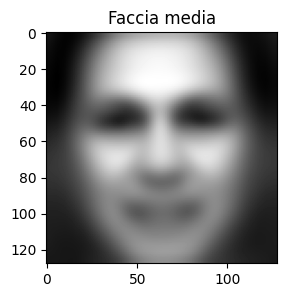

In [17]:
faceMean = np.zeros((dim,dim), dtype=np.float32)
faceNumber = 0
listOfArray = []
faceLabel = []

for key in tagFoto:
    for im in tagFoto[key]:
        vj = violajones(im)
        faceMean += vj
        flat = vj.flat
        listOfArray.append(flat)
        faceLabel.append(key)
        faceNumber+=1

faceMean /= faceNumber

#faceMean = faceMean.astype(np.uint8)
MatrixFlattenedImages = np.vstack(listOfArray)  

fig, axes = plt.subplots(1,1,sharex=True,sharey=True,figsize=(3,3))
axes.imshow(faceMean, cmap="gray")
axes.set_title("Faccia media")
plt.show()

Decommentare solo per rifare il training del modello

In [18]:
pca = PCA().fit(MatrixFlattenedImages)


with open('pca.pkl', 'wb') as pickle_file:
    pickle.dump(pca, pickle_file)

In [24]:
with open('pca.pkl', 'rb') as pickle_file:
    pca = pickle.load(pickle_file)


varianzaCumulata = pca.explained_variance_ratio_.cumsum()

index95 = list(map(lambda i: i> 0.95, varianzaCumulata)).index(True)

index9999 = list(map(lambda i: i> 0.9999, varianzaCumulata)).index(True)

print(f"numero di componenti per avere il 95%  \t{index95} \nnumero di componenti per avere il 99,99% {index9999} ")

eigenfaces95perc = pca.components_[:index95]
eigenfaces9999perc = pca.components_[:index9999]

eigenfaces = pca.components_

weights = eigenfaces @ (MatrixFlattenedImages - pca.mean_).T
weights95 = eigenfaces95perc @ (MatrixFlattenedImages - pca.mean_).T
weights9999 = eigenfaces9999perc @ (MatrixFlattenedImages - pca.mean_).T


numero di componenti per avere il 95%  	21 
numero di componenti per avere il 99,99% 1318 


In [27]:

def varyingK(k=1):

    vj = violajones("test/0.jpg",k)    
    query = vj.reshape(1,-1)
    query_weight = eigenfaces @ (query - pca.mean_).T
    euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)

    query_weight95 = eigenfaces95perc @ (query - pca.mean_).T
    euclidean_distance95 = np.linalg.norm(weights95 - query_weight95, axis=0)

    query_weight9999 = eigenfaces9999perc @ (query - pca.mean_).T
    euclidean_distance9999 = np.linalg.norm(weights9999 - query_weight9999, axis=0)

    best_match = np.argmin(euclidean_distance)

    best_match95 = np.argmin(euclidean_distance95)

    best_match9999 = np.argmin(euclidean_distance9999)

    fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,6))
    axes[0][0].imshow(query.reshape(dim,dim), cmap="gray")
    axes[0][0].set_title(f"Query, k = {k}")
    axes[0][1].imshow(MatrixFlattenedImages[best_match].reshape(dim,dim), cmap="gray")
    axes[0][1].set_title(f"{faceLabel[best_match]}\n distanza: {euclidean_distance[best_match]}")

    axes[1][0].imshow(MatrixFlattenedImages[best_match95].reshape(dim,dim), cmap="gray")
    axes[1][0].set_title(f"\n95% {faceLabel[best_match95]}\n distanza: {euclidean_distance[best_match95]}")
    axes[1][1].imshow(MatrixFlattenedImages[best_match9999].reshape(dim,dim), cmap="gray")
    axes[1][1].set_title(f"\n99% {faceLabel[best_match9999]}\n distanza: {euclidean_distance[best_match9999]}")


    plt.show()




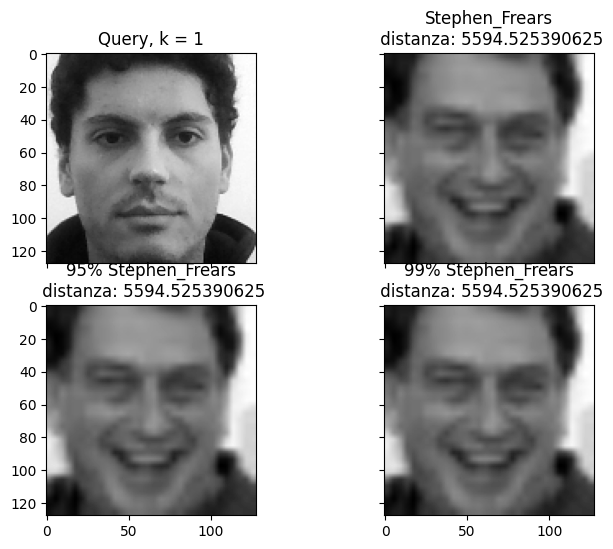

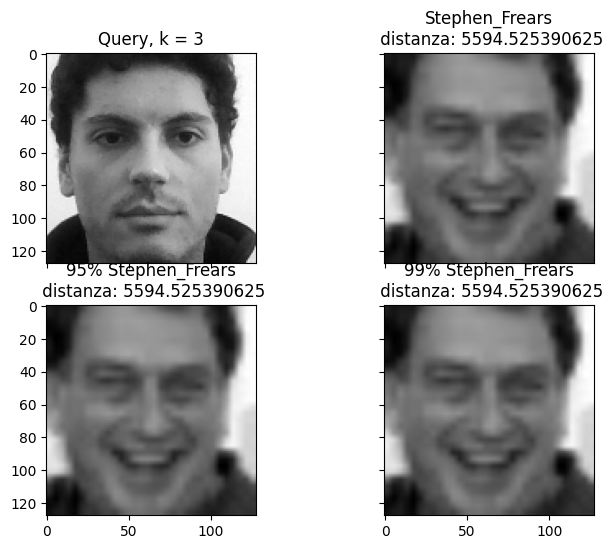

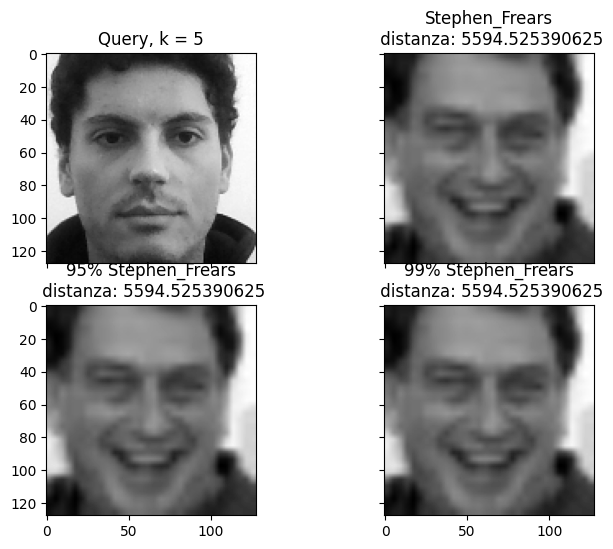

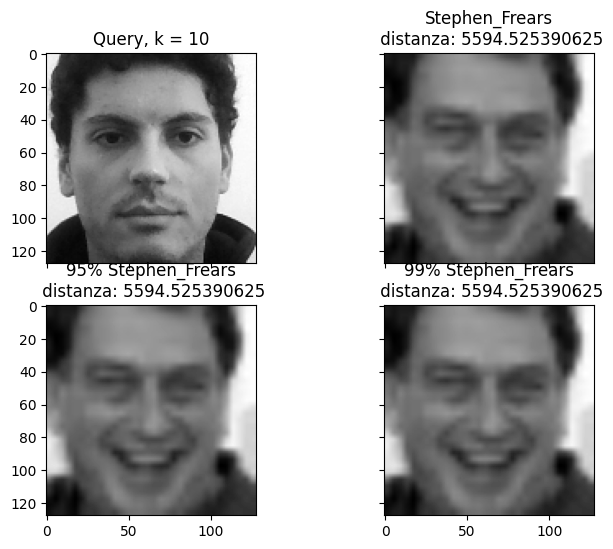

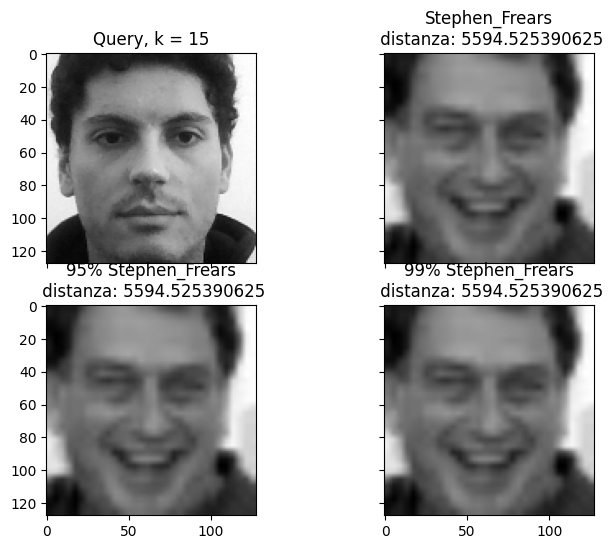

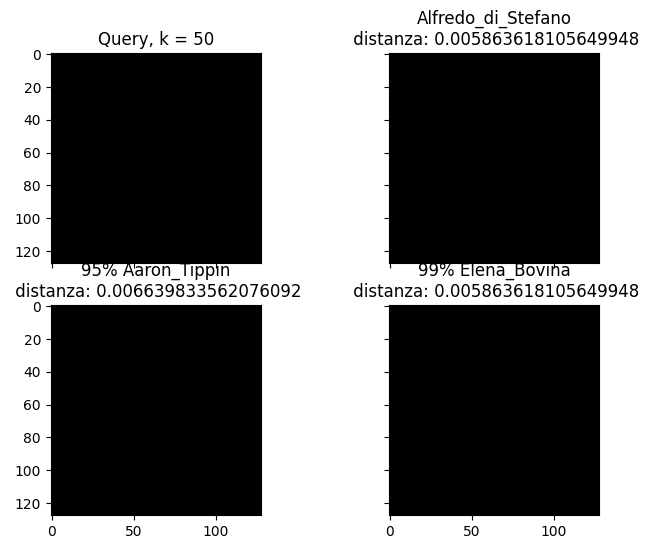

In [31]:
for k in [1,3,5]:
    varyingK(k)

In [ ]:
def violajonesMultiple(img, minNeighbors=5):
    faceROI = np.zeros((dim,dim), dtype=np.float32)
    faces = face_cascade.detectMultiScale(img,minNeighbors=minNeighbors, minSize = (10,10), maxSize=(50,50))
    listOfFaceROI = []
    pos =[]
    for (x, y, w, h) in faces:
        faceROI = img[y:y + h, x:x + w]
        faceROI = cv2.resize(faceROI,(dim,dim), interpolation=cv2.INTER_LINEAR)
        listOfFaceROI.append(faceROI)
        pos.append([(x, y), (x+w, y+h), (255, 0, 255), 4])
    return listOfFaceROI, pos

def findCorrespondence(frame, printMatplot, printCorrespondence):
    font = cv2.FONT_HERSHEY_SIMPLEX
    faceNumber = 0
    frameFaceLabel = []
    vjMul, pos = violajonesMultiple(frame)
    #print(f"trovati {len(vjMul)} volti nel frame")
    for vj in vjMul:
        query = vj.reshape(1,-1)
        query_weight = eigenfaces @ (query - pca.mean_).T
        euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
        best_match = np.argmin(euclidean_distance)
        frameFaceLabel.append(faceLabel[best_match])
        if printCorrespondence:
            print(f"Approssimazione migliore {faceLabel[best_match]}  \n Distanza euclidea {euclidean_distance[best_match]} ")
        if printMatplot: 
            fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
            axes[0].imshow(query.reshape(dim,dim), cmap="gray")
            axes[0].set_title("Query")
            axes[1].imshow(MatrixFlattenedImages[best_match].reshape(dim,dim), cmap="gray")
            axes[1].set_title(f"{faceLabel[best_match]}\n distanza: {euclidean_distance[best_match]}")
            plt.show()
    for p in pos:
        px,py = p[0]
        frame = cv2.putText(frame, frameFaceLabel[faceNumber], (px-5,py-5) ,font, 1,(255,255,255),2 )
        faceNumber+=1
        frame = cv2.rectangle(frame, p[0],p[1],p[2],p[3])
    #cv2.imshow("face detect", frame)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    return frame




In [ ]:
img = cv2.imread("test/0.jpg",0)

findCorrespondence(img,True, True)

In [ ]:
#Da decommentare in caso in cui bisogna rifare la raccolta delle facce nei video o dopo aver ricreato 
#il set dell'addestramento

#'''
video = cv2.VideoCapture("Video finale senza riconoscimento.mp4")
frames = []
if (video.isOpened()== False):
    print("Error opening video file")
while(video.isOpened()):
  ret, frame = video.read()
  if ret == True:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
  else:
      break

print("finito di raccogliere i frame")
riconosciuti=[]
for f in frames:
    riconosciuti.append(findCorrespondence(f,0,0))
print("finito di riconoscere")
with open('Riconosciuto.pkl', 'wb') as pickle_file:
        pickle.dump(riconosciuti, pickle_file)
#'''


In [ ]:
#da fixare
with open('Riconosciuto.pkl', 'rb') as pickle_file:
    riconosciuti = pickle.load(pickle_file)
height, width = riconosciuti[0].shape
size = (width,height)

print (len(riconosciuti))

print(size)

#fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fourcc = -1 

out30 = cv2.VideoWriter('project30fps.mp4',fourcc, 30, size)

for i in riconosciuti:
    out30.write(i)
out30.release()

print("Video 30 fps fatto")

'''
out60 = cv2.VideoWriter('project60fps.mp4',fourcc, 60, size)
 
for i in riconosciuti:
    out60.write(i)
out60.release()

print("Video 60 fps fatto")


out90 = cv2.VideoWriter('project90fps.mp4',fourcc, 90, size)
 
for i in riconosciuti:
    out90.write(i)
out90.release()

print("Video 90 fps fatto")
'''

